In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from numpy import loadtxt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model, Sequential
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Soil_Moisture/Train.csv')
train['timestamp'] = pd.to_datetime(train['timestamp'])
train['days'] = train['timestamp'].dt.dayofyear
train['days'] = train['days']-53

train['time_of_day'] = "lol"

for index,row in train.iterrows():
  if(row.timestamp.hour >= 0 and row.timestamp.hour <= 6):
    train.loc[index,'time_of_day'] = "Midnight"
  elif (row.timestamp.hour >= 7 and row.timestamp.hour <= 12):
    train.loc[index,'time_of_day'] = "Morning"
  elif (row.timestamp.hour >= 13 and row.timestamp.hour <= 17):
    train.loc[index,'time_of_day'] = "Afternoon"
  elif (row.timestamp.hour >= 18 and row.timestamp.hour <= 23):
    train.loc[index,'time_of_day'] = "Night"

predict = train[train['Soil humidity 1'].isna()]
train = train.dropna(subset = ['Air temperature (C)'])
train = train.dropna()

In [ ]:
train['Soil humidity 1'].mean()

63.032392865155984

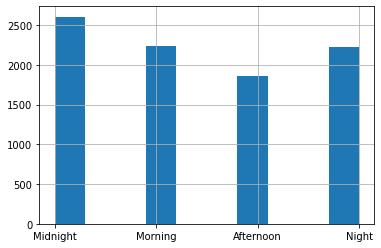

In [ ]:
train['time_of_day'].hist()


In [ ]:
X_train = train[['Air temperature (C)','Air humidity (%)','Pressure (KPa)','Wind speed (Km/h)','Wind gust (Km/h)','Wind direction (Deg)']]

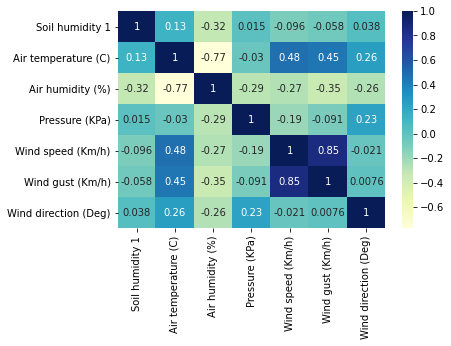

In [ ]:
dataplot = sn.heatmap(train.corr(), cmap="YlGnBu", annot=True)
plt.show()

In [ ]:
X_train = train[['Air temperature (C)','Air humidity (%)','Pressure (KPa)','Wind speed (Km/h)','Wind gust (Km/h)','Wind direction (Deg)','days','time_of_day']]
Y_train = train[['Soil humidity 1']]

In [ ]:
X_train.head()

,Air temperature (C),Air humidity (%),Pressure (KPa),Wind speed (Km/h),Wind gust (Km/h),Wind direction (Deg),days,time_of_day
0,19.52,55.04,101.50,2.13,6.30,225.00,1,Midnight
1,19.49,55.17,101.50,2.01,10.46,123.75,1,Midnight
2,19.47,55.30,101.51,1.90,14.63,22.50,1,Midnight
3,19.54,54.20,101.51,2.28,16.08,123.75,1,Midnight
4,19.61,53.09,101.51,2.66,17.52,225.00,1,Midnight


In [ ]:
print(X_train.shape,Y_train.shape)

(8914, 8) (8914, 1)


In [ ]:
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [ ]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(X_train['time_of_day'])
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = pd.DataFrame(onehot_encoder.fit_transform(integer_encoded))
X_train.join(onehot_encoded)

,Air temperature (C),Air humidity (%),Pressure (KPa),Wind speed (Km/h),Wind gust (Km/h),Wind direction (Deg),days,time_of_day,0,1,2,3
0,19.52,55.04,101.50,2.13,6.30,225.00,1,Midnight,0.0,1.0,0.0,0.0
1,19.49,55.17,101.50,2.01,10.46,123.75,1,Midnight,0.0,1.0,0.0,0.0
2,19.47,55.30,101.51,1.90,14.63,22.50,1,Midnight,0.0,1.0,0.0,0.0
3,19.54,54.20,101.51,2.28,16.08,123.75,1,Midnight,0.0,1.0,0.0,0.0
4,19.61,53.09,101.51,2.66,17.52,225.00,1,Midnight,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
8909,16.23,96.00,101.26,0.54,2.42,180.00,31,Night,0.0,0.0,0.0,1.0
8910,16.09,96.00,101.26,0.16,1.77,180.00,31,Night,0.0,0.0,0.0,1.0
8911,15.96,96.00,101.28,0.16,1.60,180.00,31,Night,0.0,0.0,0.0,1.0
8912,15.84,96.00,101.29,0.15,1.44,180.00,31,Night,0.0,0.0,0.0,1.0


In [ ]:
X_train = X_train.join(onehot_encoded)

In [ ]:
X_train.rename(columns = {1:'Midnight',0:'Afternoon',2:'Morning',3:'Night'},inplace = True)

In [ ]:
X_train.head()

,Air temperature (C),Air humidity (%),Pressure (KPa),Wind speed (Km/h),Wind gust (Km/h),Wind direction (Deg),days,time_of_day,Afternoon,Midnight,Morning,Night
0,19.52,55.04,101.50,2.13,6.30,225.00,1,Midnight,0.0,1.0,0.0,0.0
1,19.49,55.17,101.50,2.01,10.46,123.75,1,Midnight,0.0,1.0,0.0,0.0
2,19.47,55.30,101.51,1.90,14.63,22.50,1,Midnight,0.0,1.0,0.0,0.0
3,19.54,54.20,101.51,2.28,16.08,123.75,1,Midnight,0.0,1.0,0.0,0.0
4,19.61,53.09,101.51,2.66,17.52,225.00,1,Midnight,0.0,1.0,0.0,0.0


In [ ]:
from sklearn.datasets import make_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [ ]:
int_train = X_train[['Air temperature (C)','Air temperature (C)','Pressure (KPa)','Wind speed (Km/h)','Wind gust (Km/h)','Wind direction (Deg)',]]

In [ ]:
x_train_scaled = scaler.fit_transform(int_train)
x_train = pd.DataFrame(x_train_scaled)

In [ ]:
x_train = x_train.join(X_train[['days','Afternoon','Midnight','Morning','Night']])

In [ ]:
x_train.head()

,0,1,2,3,4,5,days,Afternoon,Midnight,Morning,Night
0,0.254758,0.254758,0.718750,0.071741,0.047251,0.666667,1,0.0,1.0,0.0,0.0
1,0.253837,0.253837,0.718750,0.067700,0.078452,0.366667,1,0.0,1.0,0.0,0.0
2,0.253223,0.253223,0.726563,0.063995,0.109728,0.066667,1,0.0,1.0,0.0,0.0
3,0.255371,0.255371,0.726563,0.076794,0.120603,0.366667,1,0.0,1.0,0.0,0.0
4,0.257520,0.257520,0.726563,0.089592,0.131403,0.666667,1,0.0,1.0,0.0,0.0


In [ ]:
###################################################################Training###################################################################

In [ ]:
################################################################### K Nearest Neighbour ###################################################################

In [ ]:
model = KNeighborsRegressor()
model.fit(x_train, Y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [ ]:
predicted_op = model.predict(x_train)

In [ ]:
print(predicted_op)

[[67.724]
 [67.762]
 [67.794]
 ...
 [39.668]
 [39.668]
 [39.668]]


In [ ]:
from sklearn.metrics import mean_squared_error

rms = mean_squared_error(Y_train, predicted_op, squared=False)

In [ ]:
print(rms)

0.18514935726676987


In [ ]:
###################################################################XG Boost###################################################################

In [ ]:
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor

In [ ]:
model = XGBRegressor(objective ='reg:squarederror', verbosity = 0, random_state=42)
wrapper = MultiOutputRegressor(model)
wrapper.fit(x_train,Y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            importance_type='gain',
                                            learning_rate=0.1, max_delta_step=0,
                                            max_depth=3, min_child_weight=1,
                                            missing=None, n_estimators=100,
                                            n_jobs=1, nthread=None,
                                            objective='reg:squarederror',
                                            random_state=42, reg_alpha=0,
                                            reg_lambda=1, scale_pos_weight=1,
                                            seed=None, silent=None, subsample=1,
                                           

In [ ]:
predicted_op = wrapper.predict(x_train)
print(predicted_op)

[[67.16451 ]
 [66.411156]
 [66.11024 ]
 ...
 [39.611797]
 [39.470848]
 [39.470848]]


In [ ]:
from sklearn.metrics import mean_squared_error

rms = mean_squared_error(Y_train, predicted_op, squared=False)

In [ ]:
print(rms)

2.3456572835598086


In [ ]:
###################################################################Light GBM###################################################################

In [ ]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from matplotlib import pyplot

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, x_train, Y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
model = LGBMRegressor()
model.fit(x_train, Y_train)

MAE: -0.552 (0.026)


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
predicted_op = model.predict(x_train)

In [ ]:
print(predicted_op)

[67.45631612 67.29451672 67.65806384 ... 40.09511451 40.09511451
 40.09511451]


In [ ]:
rms = mean_squared_error(Y_train, predicted_op, squared=False)
print(rms)

0.6848275531380317


In [ ]:
##################################################################### Neural Network ################################################################################

In [ ]:
y_train.loc[3024]

66.48

In [ ]:
# Regression Example With Boston Dataset: Baseline
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [ ]:
model_1 = Sequential()

# Adding the input layer and the first hidden layer
model_1.add(Dense(32, activation = 'relu', input_dim = 11))

# Adding the second hidden layer
model_1.add(Dense(units = 20, activation = 'relu'))

# Adding the third hidden layer
model_1.add(Dense(units = 32, activation = 'relu'))

model_1.add(Dense(units = 32, activation = 'relu'))

model_1.add(Dense(units = 20, activation = 'relu'))

model_1.add(Dense(units = 20, activation = 'relu'))

model_1.add(Dense(units = 32, activation = 'relu'))

# Adding the output layer
model_1.add(Dense(units = 1))

model_1.compile(optimizer = 'adam',loss = 'mean_squared_error')
model_1.fit(x_train, Y_train, batch_size = 5, epochs = 100)

Epoch 1/100
1783/1783 [==============================] - 4s 2ms/step - loss: 658.9857
Epoch 2/100
1783/1783 [==============================] - 3s 2ms/step - loss: 53.7526
Epoch 3/100
1783/1783 [==============================] - 3s 2ms/step - loss: 36.5546
Epoch 4/100
1783/1783 [==============================] - 3s 2ms/step - loss: 33.2085
Epoch 5/100
1783/1783 [==============================] - 3s 2ms/step - loss: 31.0891
Epoch 6/100
1783/1783 [==============================] - 3s 2ms/step - loss: 29.5271
Epoch 7/100
1783/1783 [==============================] - 3s 2ms/step - loss: 28.0973
Epoch 8/100
1783/1783 [==============================] - 3s 2ms/step - loss: 26.3162
Epoch 9/100
1783/1783 [==============================] - 3s 2ms/step - loss: 26.3174
Epoch 10/100
1783/1783 [==============================] - 3s 2ms/step - loss: 26.4606
Epoch 11/100
1783/1783 [==============================] - 3s 2ms/step - loss: 26.0716
Epoch 12/100
1783/1783 [==============================] - 3s 2

In [ ]:
predictions = model_1.predict(x_train)

In [ ]:
predictions[3024]

array([68.7089], dtype=float32)

In [ ]:
rms = mean_squared_error(Y_train, predictions, squared=False)
print(rms)

2.26801842628608


In [ ]:
######################################################################### Support Vector Machine ################################################################################

In [ ]:
from sklearn.svm import SVR
regressor = SVR(kernel = 'rbf')
regressor.fit(x_train, Y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [ ]:
predictions = regressor.predict(x_train)

In [ ]:
print(predictions)

[66.13472132 65.44265992 64.7407122  ... 39.76681706 39.76618693
 39.76908028]


In [ ]:
rms = mean_squared_error(Y_train, predictions, squared=False)
print(rms)

6.221653280478926
